In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import scipy.signal
%matplotlib inline

# Classification
from sklearn import tree
from sklearn import svm
from sklearn.linear_model import LogisticRegression
#import xgboost as xgb

## Load data 
and save them in a DataFrame

In [10]:
def load_data(data_file):
    df = pd.read_csv(data_file)
    T, nb_sim = np.shape(df)
    nb_sim -= 1
    print("Time horizon:", T)
    print("Number of simulations:", nb_sim)
    return nb_sim, T, df

nb_sim, T, df = load_data("out_O2_taub.csv")

('Time horizon:', 36)
('Number of simulations:', 100)


In [3]:
df.head()

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100
0,4,0.004520,0.003805,0.002963,0.003026,0.002770,0.002742,0.002827,0.002870,0.002844,...,0.003751,0.004329,0.003070,0.003132,0.003106,0.002617,0.003351,0.003112,0.003108,0.003107
1,5,0.004541,0.003759,0.003020,0.003029,0.002728,0.002754,0.002825,0.002839,0.002919,...,0.003731,0.004335,0.003094,0.003092,0.003097,0.002671,0.003345,0.003046,0.003043,0.003067
2,6,0.004524,0.003765,0.003001,0.002971,0.002779,0.002781,0.002839,0.002847,0.002808,...,0.003808,0.004420,0.003080,0.003134,0.003111,0.002617,0.003403,0.003071,0.003081,0.003097
3,7,0.004571,0.003769,0.002993,0.003043,0.002756,0.002772,0.002835,0.002866,0.002869,...,0.003824,0.004414,0.003105,0.003093,0.003101,0.002660,0.003378,0.003066,0.003081,0.003105
4,8,0.004488,0.003756,0.003018,0.003049,0.002769,0.002768,0.002879,0.002858,0.002880,...,0.003802,0.004394,0.003112,0.003090,0.003137,0.002673,0.003342,0.003071,0.003125,0.003078


In [4]:
def plot_data(df):
    variables = [col for col in list(df.columns) if 'V' in col]
    
    plt.figure()
    for col in variables:
        plt.plot(df[col])
    plt.title('O2 evolution on {} simulations'.format(len(variables)))
    plt.ylabel('O2')
    plt.xlabel('time')
    plt.show()

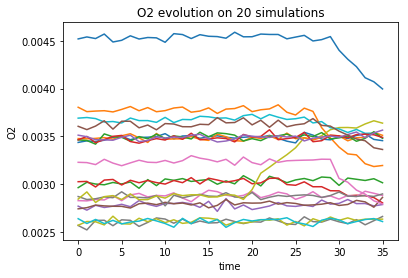

In [5]:
var = ['V' + str(i) for i in range(1, 21)]
plot_data(df[var])

## Set the parameters:
* **len_X**: the len_x last values of X are taken into account to compute descriptors
* **tau**: We want to predict if an accident happens at t + tau

The following variables are used to determine the event: "accident" that we want to predict:
* **thres_mean**: If |mean(X(0), ..., (t-1)) - X(t)| < thres_mean, then there is an accident at t.
* **X0_base, thres_gal**: If |X(t) - X0| < thres_gal then there is an accident.

In [6]:
params = {'len_X': 10,
          'tau': 5,
          'thres_mean': 1e-4,
          'X0_base': 0.0042,
          'thres_gal': 0.2}

variables = [col for col in list(df.columns) if 'V' in col]

### Processing X data and compute the accident variable Y

In [7]:
def process_var(df, variables):
    
    # Concatenation des x
    X = []
    trajec = []
    X_cummean = []

    for j in range(len(variables)):
        col = variables[j]
        X += list(df[col])
        # Trajec = the number of the trajectory
        trajec += [j for _ in range(len(df))]

        # CumMean of X (t-1 previous values)
        cummean = np.cumsum(df[col]) / np.array(range(1, len(df)+1))
        X_cummean += [df[col][0]] + list(cummean[:-1])

    data = pd.DataFrame({'X': X, 'trajec': trajec, 'X_cummean': X_cummean})
    
    # Compute Y
    data['X_diff'] = abs(data['X'] - data['X_cummean'])
    # The difference between X and the cummean is it below the threshold thres_mean ?
    data['Y1'] = data['X_diff'].apply(lambda x: 1 if x > params['thres_mean'] else 0)
    # The value of X is it below the general threshold thres_gal ?
    data['Y2'] = data['X'].apply(lambda x: 1 if abs(x - params['X0_base']) > params['thres_gal'] else 0)

    # The incident happens if one of the two previous event happen
    data['Y'] = data['Y1'] + data['Y2']
    data['Y'] = data['Y'].apply(lambda x: 1 if x > 0 else 0)
    
    return data

data = process_var(df, variables)

In [123]:
def plot_Y_X_diff(num_trajec):
    trajec_data = data[data['trajec'] == num_trajec]
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.plot(trajec_data['X_diff'], label='X_diff', color='r')
    ax2.plot(trajec_data['Y'], label='Y', color='black')

    ax1.legend()
    ax2.legend()
    plt.title("X_diff and the Y computed for the trajectory {}".format(num_trajec))
    plt.show()

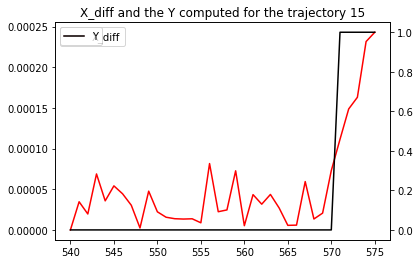

In [134]:
plot_Y_X_diff(15)

**trajec** is the number of the trajectory. When the number change, the value correspond to a new person.

In [145]:
print("{}% of the points are an accident".format(round(np.sum(data['Y'])/ len(data) * 100, 2)))

print("{} patient over the {} patients have an accident".format(len(data[data['Y'] == 1]['trajec'].unique()), nb_sim))

12.03% of the points are an accident
40 patient over the 100 patients have an accident


## Compute descriptors on X data

In [12]:
def lowpass(signal):
    b,a = scipy.signal.iirdesign(0.3, 0.4, 3, 60, analog=False, ftype='cheby2', output='ba')
    temp1 = scipy.signal.lfilter(b, a, signal, axis=-1, zi=None)
    temp2 = scipy.signal.lfilter(b, a, temp1, axis=-1, zi=None)
    filtered_signal = scipy.signal.filtfilt(b, a, signal)
    return filtered_signal

In [89]:
# Separate data x in windows of lenght len_X
# and compute descriptors on this window

descriptors = {'X': [], 'Y': [], 'trajec': [],
               'mean': [],
               'diff_to_mean': [],
               'diff_first_second_mean': [],
               'diff_to_X0': [],
               'actual_evolution': [], 
               'past_evolution': [], 
               'mean_past_evolution': [],
                'filtered_signal':[]}

for i in range(1, params['len_X'] + 1):
    descriptors['X_{}'.format(i)] = []

nb_trajec = len(np.unique(data['trajec']))

for n in range(nb_trajec):

    for j in range(params['len_X'], T - params['tau']):
        i = n*T + j
        X_ = list(data['X'][i - params['len_X']:i])  # Past
        
        descriptors['X'].append(data['X'][i])
        descriptors['Y'].append(data['Y'][i])
        descriptors['trajec'].append(data['trajec'][i])

        descriptors['mean'].append(np.mean(X_))
        descriptors['diff_to_mean'].append(np.abs(data['X'][i] - np.mean(X_)))
        descriptors['diff_first_second_mean'].append(np.abs(np.mean(X_[:int(params['len_X']/2)])\
                                                            - np.mean(X_[int(params['len_X']/2):])))
        descriptors['diff_to_X0'].append(np.abs(np.mean(X_) - params['X0_base']))
        descriptors['actual_evolution'].append(data['X'][i] - data['X'][i-1])
        
        past_evolution = [X_[k] - X_[k-1] for k in range(1, len(X_))]
        descriptors['past_evolution'].append(past_evolution)
        descriptors['mean_past_evolution'].append(np.mean(past_evolution))

        
        # Past values
        for k in range(1, params['len_X'] + 1):
            descriptors['X_{}'.format(k)].append((data['X'][i - k]))
    
    traj = data['X'][n*T:(n+1)*T]
    traj = traj - np.mean(traj)
    filtered_traj = lowpass(traj)
    filtered_traj = filtered_traj[params['len_X']: T - params['tau']]
    descriptors['filtered_signal'].extend((filtered_traj).tolist())

print(len(descriptors['diff_to_mean']), len(descriptors['filtered_signal']))


descriptors = pd.DataFrame(descriptors)

name_descriptors = list(descriptors.columns)
name_descriptors.remove('X')
name_descriptors.remove('Y')
name_descriptors.remove('trajec')
print("The descriptors computed are:", name_descriptors)
print("{} trajectories of length {}".format(nb_trajec, T))

(2100, 2100)
('The descriptors computed are:', ['X_1', 'X_10', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8', 'X_9', 'actual_evolution', 'diff_first_second_mean', 'diff_to_X0', 'diff_to_mean', 'filtered_signal', 'mean', 'mean_past_evolution', 'past_evolution'])
100 trajectories of length 36


In [62]:
print(data['X'].shape)

(3600,)


### Correlation coefficients

In [90]:
pure_descriptors_names = [x for x in name_descriptors if x[:2] != 'X_'] + ['X', 'Y']

print("Correlation coefficients between the variables:")
descriptors[pure_descriptors_names].corr()

Correlation coefficients between the variables:


,actual_evolution,diff_first_second_mean,diff_to_X0,diff_to_mean,filtered_signal,mean,mean_past_evolution,X,Y
actual_evolution,1.000000,-0.060220,0.117368,-0.128706,0.194707,-0.125342,0.226221,0.003733,-0.042202
diff_first_second_mean,-0.060220,1.000000,-0.131517,0.839924,-0.213854,0.096846,-0.306913,0.045406,0.697307
diff_to_X0,0.117368,-0.131517,1.000000,-0.156952,-0.105280,-0.952739,0.128929,-0.929987,-0.119507
diff_to_mean,-0.128706,0.839924,-0.156952,1.000000,-0.177371,0.134704,-0.277525,0.074524,0.812988
filtered_signal,0.194707,-0.213854,-0.105280,-0.177371,1.000000,0.137975,0.712776,0.274959,-0.047734
mean,-0.125342,0.096846,-0.952739,0.134704,0.137975,1.000000,-0.127570,0.977283,0.086815
mean_past_evolution,0.226221,-0.306913,0.128929,-0.277525,0.712776,-0.127570,1.000000,0.057637,-0.053589
X,0.003733,0.045406,-0.929987,0.074524,0.274959,0.977283,0.057637,1.000000,0.076528
Y,-0.042202,0.697307,-0.119507,0.812988,-0.047734,0.086815,-0.053589,0.076528,1.000000


**Remarques:**
La variable à prédire Y est fortement corrélées avec les deux variables decrivant la différence à la moyenne passée ('diff_to_mean', 'diff_first_second_mean'). Ces deux variables sont aussi corrélées, il vaut mieux choisir l'une des deux.

### Plot descriptors

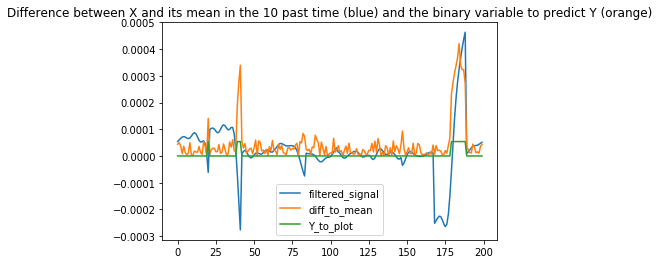

In [92]:
descriptors['Y_to_plot'] = descriptors['Y'] * descriptors['diff_to_mean'].mean()

#descriptors[['diff_to_mean', 'Y_to_plot']][:].plot()
descriptors[['filtered_signal', 'diff_to_mean','Y_to_plot']][:200].plot()
plt.title('Difference between X and its mean in the {} past time (blue) and \
the binary variable to predict Y (orange)'.format(params['len_X']))
plt.show()

La corrélation est assez marquante entre la variable "différence avec la moyenne passée" et l'apparition d'un accident.

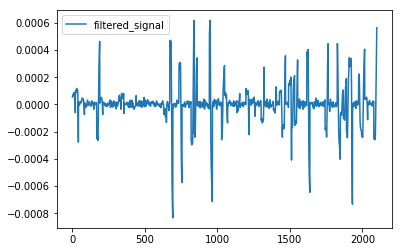

In [93]:
descriptors[['filtered_signal']][:].plot()

In [94]:
# Liste des trajectoires qui degenerent:

trajec_accident = []

for trajec in range(nb_sim):
    if len(np.unique(descriptors[descriptors['trajec'] == trajec]['Y'])) > 1:
        trajec_accident.append(trajec)
        
np.reshape(trajec_accident, (1, len(trajec_accident)))

array([[ 0,  1,  8,  9, 16, 20, 32, 35, 39, 40, 45, 49, 50, 54, 57, 59,
        62, 66, 68, 69, 71, 72, 73, 77, 83, 87, 88, 89, 90, 91, 94, 95,
        96, 99]])

In [67]:
def plot_trajec_diff_to_mean(trajec_data):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax3 = ax1.twinx()

    ax1.plot(trajec_data['X'], label='X', color='r')
    ax2.plot(trajec_data['diff_to_mean'], label='diff_to_mean', color='b')
    ax3.plot(trajec_data['Y'], label='Y', color='black')

    ax3.legend()
    ax1.legend()
    ax2.legend()
    plt.title("Evolution of the descriptors of a patient having an accident")
    plt.show()

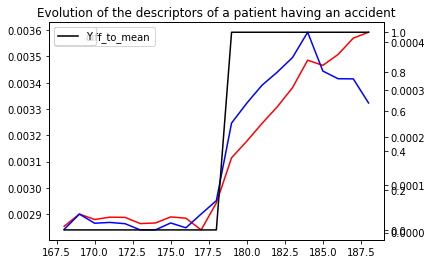

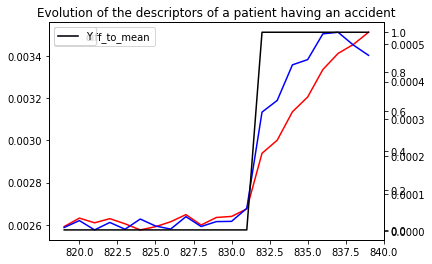

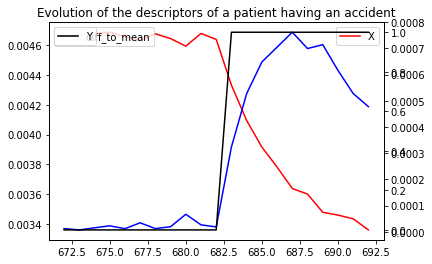

In [68]:
trajec1 = descriptors[descriptors['trajec'] == 8]
plot_trajec_diff_to_mean(trajec1)
plot_trajec_diff_to_mean(descriptors[descriptors['trajec'] == 39])
plot_trajec_diff_to_mean(descriptors[descriptors['trajec'] == 32])

### Equilibrer les classes 

Il est important d'équilibrer les classes, i.e. avoir autant de données avec Y=1 et Y=0 pour entrainer un classifieur.

In [69]:
print(np.unique(descriptors['Y']))
len_Y1 = np.sum(descriptors['Y'])
len_Y0 = -np.sum([x - 1 for x in descriptors['Y']])
print("In the original database:")
print("Y=1:", len_Y1, "data")
print("Y=0:", len_Y0, "data")

[0 1]
In the original database:
('Y=1:', 247, 'data')
('Y=0:', 1853, 'data')


In [71]:
X1 = descriptors[descriptors['Y'] == 1]
X0 = descriptors[descriptors['Y'] == 0]
indices = np.random.permutation(range(len(X0)))

if len_Y1 < len_Y0:
    new_X0 = X0.iloc[indices[:len_Y1]]
    new_X1 = X1
else:
    new_X0 = X0
    new_X1 = X1.iloc[indices[:len_Y0]]
    
new_X = pd.concat((new_X0, new_X1))

print("In the new database:")
print("Y=1:", np.sum(new_X['Y']), "data")
print("Y=0:", -np.sum([x - 1 for x in new_X['Y']]), "data")

In the new database:
('Y=1:', 247, 'data')
('Y=0:', 247, 'data')


# Classification

#### Choose descriptors

In [72]:
print("Available descriptors:", name_descriptors)

('Available descriptors:', ['X_1', 'X_10', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8', 'X_9', 'actual_evolution', 'diff_first_second_mean', 'diff_to_X0', 'diff_to_mean', 'filtered_signal', 'mean', 'mean_past_evolution', 'past_evolution'])


In [81]:
# Choose a list of descriptors:
#list_descriptors = ['diff_to_mean', 'X']
list_descriptors = ['filtered_signal']

#### Separate data in test and train set

In [82]:
X_data = np.array(new_X[list_descriptors])
Y_data = np.array(new_X['Y'])

# Separate train / test
pct_test = 0.2
nb_test = int(pct_test * len(X_data))
print("{} data in the test set and {} in the train set".format(nb_test, len(X_data) - nb_test))
indices = np.random.permutation(range(len(X_data)))

X_test = X_data[indices[:nb_test]]
Y_test = Y_data[indices[:nb_test]]

X_train = X_data[indices[nb_test:]]
Y_train = Y_data[indices[nb_test:]]

98 data in the test set and 396 in the train set


In [83]:
print(np.shape(X_train))

(396, 1)


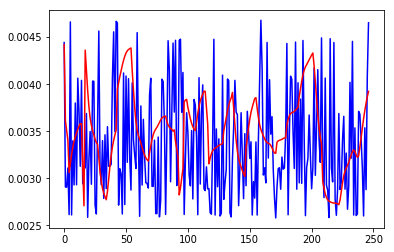

In [84]:
plt.plot(X_data[Y_data == 0][:, 0], color='b')
plt.plot(X_data[Y_data == 1][:, 0], color='r')

plt.show()

In [80]:
Y_predict = X_test[:, 0] > 0.00008
Y_predict = [int(y) for y in Y_predict]

# Score
print("Score {}%".format(round(np.sum(Y_predict == Y_test) / len(Y_test) * 100, 2)))

Score 0.0%


## Test several classifiers

In [171]:
def test_classif_model(model, X_train, Y_train, X_test, Y_test):
    
    model.fit(X_train, Y_train)

    score_train = model.score(X_train, Y_train)
    print("Score on train set: {}%".format(round(score_train*100, 3)))
    score_test = model.score(X_test, Y_test)
    print("Score on test set: {}%".format(round(score_test*100, 3)))

In [172]:
# Classification using a SVM (Support Vector Machine)
print("-- Linear SVM --")
lin_clf = svm.SVC()
test_classif_model(lin_clf, X_train, Y_train, X_test, Y_test)

print("-- Logistic Regression --")
logreg = LogisticRegression()
test_classif_model(logreg, X_train, Y_train, X_test, Y_test)

print("-- Trees --")
TreeClassif = tree.DecisionTreeClassifier()
test_classif_model(TreeClassif, X_train, Y_train, X_test, Y_test)

-- Linear SVM --
Score on train set: 50.758%
Score on test set: 46.939%
-- Logistic Regression --
Score on train set: 50.758%
Score on test set: 46.939%
-- Trees --
Score on train set: 100.0%
Score on test set: 97.959%


In [173]:
# Coefficients de la regression logistique...
logreg.coef_

array([[ 0.02564651,  0.01364359]])

In [174]:
# find threshold for the tree classification

for i in range(1000):
    test = TreeClassif.predict([[(i/100)*10**(-5), 100]])
    if test[0] == 1:
        seuil = (i/100)*10**(-5)
        print("Seuil:", (i/100)*10**(-5))
        break

TreeClassif.predict([[seuil - 1e-7, 100]])[0] , TreeClassif.predict([[seuil, 100]])[0]

Seuil: 5.56e-05


(0, 1)

## Online prediction

In [175]:
np.shape(X_data)

(494, 2)

In [176]:
list_descriptors = ['diff_to_mean']

len_simu_past = len(descriptors[descriptors['trajec'] == 0])
nb_simu_offline = 20

X_offline = descriptors[list_descriptors + ['X', 'trajec']].iloc[:len_simu_past*nb_simu_offline]
Y_offline = descriptors['Y'].iloc[:len_simu_past*nb_simu_offline]

X_online = descriptors[list_descriptors + ['X', 'trajec']].iloc[len_simu_past*nb_simu_offline:]
Y_online = descriptors['Y'].iloc[len_simu_past*nb_simu_offline:]

In [177]:
# Train offline

tree_model = tree.DecisionTreeClassifier()
tree_model.fit(X_offline, Y_offline)

score_train = tree_model.score(X_offline, Y_offline)
score_test = tree_model.score(X_online, Y_online)
print("Score offline {}%, score online {}%".format(round(score_train*100, 2), round(score_test*100, 2)))

Score offline 100.0%, score online 97.44%


In [178]:
y_predict = tree_model.predict(X_online)

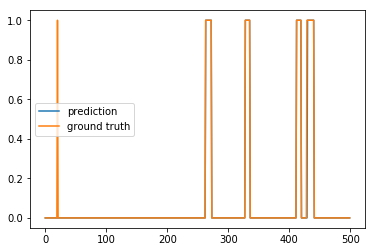

In [179]:
N = 500
plt.plot(y_predict[:N], label='prediction')
plt.plot(np.array(Y_online[:N]), label='ground truth')
plt.legend()
plt.show()

In [180]:
retard_predict = {}

for num_trajec in np.unique(X_online['trajec']):
    X_trajec = X_online[X_online['trajec'] == num_trajec]
    Y_trajec = np.array(Y_online[X_online['trajec'] == num_trajec])
    y_pred_trajec = np.array(y_predict[X_online['trajec'] == num_trajec])
    
    retard_predict[num_trajec] = 0

    for i in range(len(X_trajec)):
        if Y_trajec[i] == 1 and y_pred_trajec[i] == 0:
            retard_predict[num_trajec] += 1
            
        elif y_pred_trajec[i] == 1 and Y_trajec[i] == 0:
            retard_predict[num_trajec] -= 1

In [182]:
def plot_trajec_pred(num_trajec):
    X_trajec = X_online[X_online['trajec'] == num_trajec]
    Y_trajec = np.array(Y_online[X_online['trajec'] == num_trajec])
    y_pred_trajec = np.array(y_predict[X_online['trajec'] == num_trajec])
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.plot(np.array(X_trajec['X']), label='X', color='b')
    ax2.plot(Y_trajec, label='ground truth', color='r')
    ax2.plot(y_pred_trajec, label='prediction', color='orange')

    ax1.legend()
    ax2.legend()
    plt.title("Trajectory {}".format(num_trajec))
    plt.show()

In [184]:
[(k, retard_predict[k]) for k in retard_predict if retard_predict[k] !=0]

[(20, 1),
 (40, 1),
 (49, 2),
 (50, 3),
 (54, 1),
 (57, 1),
 (59, 1),
 (66, 1),
 (72, 3),
 (73, 1),
 (77, 1),
 (87, 4),
 (88, 8),
 (89, 4),
 (90, 1),
 (94, 6),
 (95, 1),
 (99, 1)]

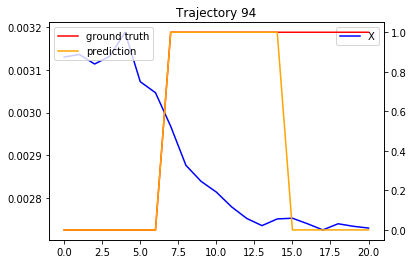

In [190]:
plot_trajec_pred(94)

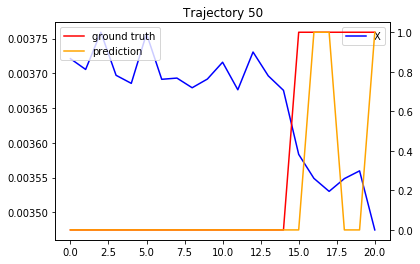

In [191]:
plot_trajec_pred(50)

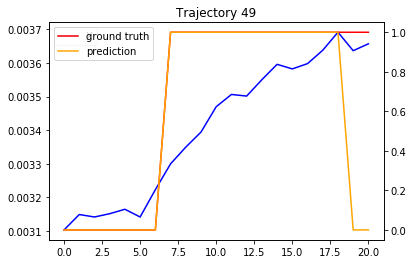

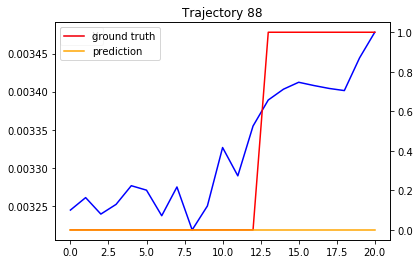

In [189]:
plot_trajec_pred(49)
plot_trajec_pred(88)